In [1]:
import torch
import random
import numpy as np
import os
from torch import nn
from torch.utils.data import Dataset,DataLoader
import matplotlib.pyplot as plt

corpus_file = '../hw2.1_corpus.txt'

In [2]:
# Load Corpus

corpus = []
with open(corpus_file, 'r', encoding='utf-8') as f:
    for row in f:
        row = row.replace('\n','')
        row = [w for w in row]
        corpus.append(row)

In [3]:
# Use list to guarantee the embedded index for each word are same everytime

words = []
words_set = set()
for ws in corpus:
    for w in ws:
        if w not in words_set:
            words_set.add(w)
            words.append(w)

In [4]:
import re

class Embedding:

    def __init__(self,words=None,dim=300):
        self.word_dict = {}
        self.word_list = []
        self.emb_dim = dim
        self.maxPOS = 12      # Maximum POS
        self.addition_words = ['<PAD>','<SOS>','<EOS>','<UNK>']
        
        for POS in range(self.maxPOS):
            self.addition_words.append(str(POS))
        
        for addition_word in self.addition_words:
            if addition_word not in words:
                self.word_dict[addition_word] = len(self.word_list)
                self.word_list.append(addition_word)
        
        for word in words:
            if word not in self.word_dict:
                self.word_dict[word] = len(self.word_list)
                self.word_list.append(word)
                
        self.vectors = torch.nn.init.uniform_(
                torch.empty(len(self.word_dict),dim))
        
    def to_index(self, word):
        # single word tokenize
        if word not in self.word_dict:
            return self.word_dict['<UNK>']
        
        return self.word_dict[word]
        
    def tokenize(self, words):
        # whole sentence tokenize
        return [self.to_index(w) for w in words]
    
    def to_word(self, idx):
        
        return self.word_list[idx]
        
    def unTokenize(self,ids):
        
        return [self.to_word(idx) for idx in ids]
        
    def get_vocabulary_size(self):
        return self.vectors.shape[0]
    
    def get_dim(self):
        return self.vectors.shape[1]

In [5]:
# establish embedder to tokenize
embedder = Embedding(words=words,dim=300)

PAD = embedder.to_index('<PAD>')
SOS = embedder.to_index('<SOS>')
EOS = embedder.to_index('<EOS>')

In [6]:
all_set = []
two_hint_ratio = 0.0

for former,latter in zip(corpus[:-1],corpus[1:]):
    
    n = len(latter)
    addition_tokens = []
    
    hint_word = 2 if random.random() < two_hint_ratio else 1

    selected_idice = random.sample(list(range(min(n,embedder.maxPOS))), k=min(n,hint_word))
    
    for selected_idx in selected_idice:
        
        addition_tokens.append(str(selected_idx+1))
        addition_tokens.append(latter[selected_idx])
    
    former = ['<SOS>'] + former + ['<EOS>'] + addition_tokens
    latter = ['<SOS>'] + latter + ['<EOS>']
    
    
    all_set.append((former,latter))

In [7]:
from sklearn.model_selection import train_test_split

train_set,valid_set = train_test_split(all_set,test_size=0.2,random_state=42)

print(len(all_set),len(train_set),len(valid_set))

741714 593371 148343


In [8]:
# list of turple : [(x0,y0),(x1,y1),(x2,y2),....]
all_set[5]

(['<SOS>',
  '你',
  '最',
  '想',
  '去',
  '的',
  '目',
  '的',
  '地',
  '剩',
  '多',
  '少',
  '公',
  '里',
  '<EOS>',
  '3',
  '也'],
 ['<SOS>', '累', '了', '也', '没', '关', '系', '我', '可', '以', '暂', '停', '<EOS>'])

In [9]:

class SentDataset(Dataset):
    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        
        return self.data[index]
        
    def collate_fn(self, datas):
        # get max length in this batch
        max_data_len = max([len(data[0]) for data in datas])
        max_label_len = max([len(data[1]) for data in datas])
        
        batch_x = []
        batch_y = []
        len_x = []
        len_y = []
        batch_y_ = []
        
        
        for data,label in datas:
            
            len_x.append(len(data))
            len_y.append(len(label))
            
            # Tokenize
            pad_data = embedder.tokenize(data)
            pad_label = embedder.tokenize(label)
            
            # Padding data and label
            if len(data) < max_data_len:
                pad_data.extend([PAD] * (max_data_len-len(data)))
            if len(label) < max_label_len:
                pad_label.extend([PAD] * (max_label_len-len(label)))
                
                
            batch_x.append(pad_data)
            batch_y.append(pad_label)
            
            # generate y_
            focus_designate = [PAD] * len(pad_label)
            focus_designate[0] = SOS
            focus_designate[pad_label.index(EOS)] = EOS
            
            for i in range(data.index('<EOS>')+1,len(data),2):
                
                idx = int(data[i])
                focus_designate[idx] = pad_label[idx]
            
            batch_y_.append(focus_designate)
            
            
        return torch.LongTensor(batch_x), torch.LongTensor(len_x), torch.LongTensor(batch_y), len_y, torch.LongTensor(batch_y_)

In [10]:
# For Validate~~~~

dataset = SentDataset(train_set)
dataloader = DataLoader(dataset=dataset,
                        batch_size=4,
                        shuffle=True,
                        collate_fn=dataset.collate_fn,
                        num_workers=0)
for x,x_len,y,y_len,y_ in dataloader:
    print('Sentence length:',x_len,y_len,'\n')
    
    for xi,yi,y_i in zip(x,y,y_):      
        
        print(embedder.unTokenize(xi))
        print(embedder.unTokenize(yi))
        print(embedder.unTokenize(y_i),'\n')
    
    break


Sentence length: tensor([15, 11, 12, 12]) [7, 9, 4, 15] 

['<SOS>', '它', '不', '必', '担', '心', '灯', '光', '烧', '灼', '着', '它', '<EOS>', '2', '灯']
['<SOS>', '有', '灯', '光', '保', '护', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
['<SOS>', '<PAD>', '灯', '<PAD>', '<PAD>', '<PAD>', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>'] 

['<SOS>', '人', '人', '向', '前', '齐', '步', '上', '<EOS>', '5', '寻', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
['<SOS>', '步', '步', '向', '上', '寻', '理', '想', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
['<SOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '寻', '<PAD>', '<PAD>', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>'] 

['<SOS>', '潜', '夫', '论', '东', '汉', '王', '符', '著', '<EOS>', '2', '卷', '<PAD>', '<PAD>', '<PAD>']
['<SOS>', '十', '卷', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
['<SOS>', '<PAD>', '卷', '<EOS>', '<PAD>', 

In [11]:
from torch.nn.utils.rnn import  pack_padded_sequence, pad_packed_sequence

class Encoder(nn.Module):

    def __init__(self, vocab_size, embedding_size, output_size):
        
        super(Encoder, self).__init__()

        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(vocab_size,embedder.get_dim())
        self.embedding.weight = nn.Parameter(embedder.vectors)
        self.gru = nn.GRU(embedding_size, output_size,batch_first=True, bias=False)

    def forward(self, input_seqs, input_lengths, hidden=None):
        
        # Sort mini-batch by input_lengths
        sorted_input_lengths, indices = torch.sort(input_lengths,descending=True)
        _, desorted_indices = torch.sort(indices, descending=False)
        input_seqs = input_seqs[indices]
        
        # Encoder work
        embedded = self.embedding(input_seqs)
        packed = pack_padded_sequence(embedded, sorted_input_lengths.cpu().numpy(), batch_first=True)
        packed_outputs, hidden = self.gru(packed, hidden)
        outputs, output_lengths = pad_packed_sequence(packed_outputs,batch_first=True)
        
        # Desort mini-batch
        outputs = outputs[desorted_indices]
        hidden = hidden[:,desorted_indices]
        
        return outputs, hidden

In [12]:
class Decoder(nn.Module):

    def __init__(self, hidden_size, output_size, teacher_forcing_ratio=0.5):
        super(Decoder, self).__init__()

        self.hidden_size = hidden_size
        self.output_size = output_size
        self.embedding = nn.Embedding(embedder.get_vocabulary_size(),embedder.get_dim()) # Unused
        self.embedding.weight = nn.Parameter(embedder.vectors)
        self.cell = nn.GRUCell(embedder.get_dim(), hidden_size, bias=False)
        self.clf = nn.Linear(hidden_size, output_size, bias=False)
        
        if hidden_size == embedder.vectors.T.shape[0]:
            self.clf.weight = nn.Parameter(embedder.vectors)

        self.log_softmax = nn.LogSoftmax(dim=1)  # work with NLLLoss

        self.teacher_forcing_ratio = teacher_forcing_ratio

    def forward_step(self, inputs, hidden):
        
        # Unused
        embedded = self.embedding(inputs)
        # For research : all x to 0
        embedded = torch.zeros_like(embedded)
        
        hidden = self.cell(embedded, hidden) # [B,Hidden_dim]
        clf_output = self.clf(hidden) # [B,Output_dim]
        output = self.log_softmax(clf_output)

        return output, hidden

    def forward(self, context_vector, target_vars, target_lengths):

        batch_size = context_vector.shape[1]
        
        decoder_input = torch.LongTensor([SOS] * batch_size).to(device)
        decoder_hidden = context_vector.squeeze(0)

        if target_lengths is None:
            max_target_length = 50
        else:
            max_target_length = max(target_lengths)
        decoder_outputs = []
        decoder_hiddens = []

        use_teacher_forcing = True if random.random() < self.teacher_forcing_ratio else False
        
        for t in range(max_target_length):    
            
            decoder_outputs_on_t, decoder_hidden = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_outputs_on_t)
            decoder_hiddens.append(decoder_hidden)
            
            # Take input for next GRU iteration
            if use_teacher_forcing :
                decoder_input = target_vars[:,t]
            else:
                decoder_input = decoder_outputs_on_t.argmax(-1)
            
            # Early Stop when all predict <EOS> 
            if torch.all(decoder_input==EOS) and target_lengths is None and self.train() == False:
                break
            
        # Stack output of each word at dimension 2
        decoder_outputs = torch.stack(decoder_outputs,dim=2)
        # Stack hidden of each timestep at dimension 1
        decoder_hiddens = torch.stack(decoder_hiddens,dim=1)
        
        return decoder_outputs, decoder_hiddens

In [13]:
class Seq2Seq(nn.Module):
    def __init__(self,encoder,decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
    
    def forward(self, input_seqs, input_lengths, target_seqs=None, target_lengths=None):
        outputs, hidden = encoder(input_seqs, input_lengths)
        outputs, hiddens = decoder(hidden, target_seqs, target_lengths)
        return outputs,hiddens

In [14]:
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

context_dim = 128

encoder = Encoder(embedder.get_vocabulary_size(),embedder.get_dim(),output_size=context_dim)
decoder = Decoder(context_dim,embedder.get_vocabulary_size(),0.5)
model = Seq2Seq(encoder,decoder)
model.to(device)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(6575, 300)
    (gru): GRU(300, 128, bias=False, batch_first=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(6575, 300)
    (cell): GRUCell(300, 128, bias=False)
    (clf): Linear(in_features=128, out_features=6575, bias=False)
    (log_softmax): LogSoftmax()
  )
)

# Training ( Dont run when analysing )

In [15]:
# def run_epoch(epoch,dataset,isTraining):
    
#     if isTraining:
#         model.train()
#     else:
#         model.eval()
        
#     dataloader = DataLoader(dataset=dataset,
#                             batch_size=32,
#                             shuffle=True,
#                             collate_fn=dataset.collate_fn,
#                             num_workers=0)
    
#     if isTraining:
#         desc='Train {}'
#     else:
#         desc='Valid {}'
    
#     trange = tqdm(enumerate(dataloader), total=len(dataloader),desc=desc.format(epoch))
    
#     loss=0
#     acc = 0
    
#     for i,(x,x_len,y,y_len,y_) in trange:
        
#         x = x.to(device)
#         y = y.to(device)
#         y_ = y_.to(device)
        
#         # outputs : [b,emb,s] , hiddens : [b,s,hidden]
#         outputs,hiddens = model(x,x_len,y,y_len)
        
#         idx = y_>2
#         tf_map = y_[idx] == outputs.argmax(1)[idx]
#         batch_acc = tf_map.sum().cpu().float().numpy()/len(tf_map)
#         acc += batch_acc
        
#         batch_loss_all = criterion(outputs, y)
#         batch_loss_designated = criterion(outputs, y_)
#         batch_loss = (1-focus_ratio)*batch_loss_all + focus_ratio*batch_loss_designated
        
#         if isTraining:
#             optimizer.zero_grad()
#             batch_loss.backward()
#             optimizer.step()
        
#         loss += batch_loss.item()
        
#         trange.set_postfix({'loss':loss/(i+1),'accuracy':acc/(i+1)})
        
#         if isTraining:
#             history_loss['train'].append(batch_loss.item())
#             history_acc['train'].append(batch_acc)
#         else:
#             history_loss['valid'].append(batch_loss.item())
#             history_acc['valid'].append(batch_acc)

In [16]:
# # Training

# dataset_all = SentDataset(all_set)
# dataset_train = SentDataset(train_set)
# dataset_valid = SentDataset(valid_set)

# criterion = torch.nn.NLLLoss(ignore_index=PAD, size_average=True)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# max_epoch = 20
# focus_ratio = 0.5

# history_loss = {'train':[],'valid':[]}
# history_acc = {'train':[],'valid':[]}


# for epoch in range(max_epoch):
    
#     # Training
#     run_epoch(epoch,dataset=dataset_train,isTraining=True)
    
#     # Validation
#     run_epoch(epoch,dataset=dataset_valid,isTraining=False)
    
#     # Saving
#     if not os.path.exists('model'):
#         os.makedirs('model')
#     torch.save(model.state_dict(), 'model/model.pkl.{}'.format(epoch))

# Plot (Loss and acc)  ( Dont run when analysis )

In [17]:
# import matplotlib.pyplot as plt

# modes = ['train', 'valid']
# recs = [history_loss, history_acc]
# names = ['Loss', 'Accuracy']

# values = []
# for mode in modes:
#     v = []
#     for rec in recs:
#         v.append(rec[mode])
#     values.append(v)

# plt.figure(figsize=(32, 4))
# plt.subplots_adjust(left=0.02, right=0.999)
# for r, name in enumerate(names):
#     plt.subplot(1, len(recs), r+1)
#     for m in range(len(modes)):
#         plt.plot(values[m][r])
#     plt.title(name)
#     plt.legend(modes)
#     plt.xlabel('iteration')
#     plt.show()
# #plt.savefig('figure.png', dpi=100)

## Convert models into directly-pickled format to solve cross-platform inconsistency

In [18]:
# import pickle

# path = 'pre-train/model.pkl.2-1-1'
# with open(path+'.state_dict', 'wb') as f:
#     pickle.dump(model.cpu().state_dict(), f)

# Inference Test Data

## Define test data dataloader

In [19]:
class TestDataset(Dataset):
    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index]
        
    def collate_fn(self, datas):
        max_data_len = max([len(data) for data in datas])
        batch_x = []
        len_x = []
        
        for data in datas:
            len_x.append(len(data))
            pad_data = [embedder.to_index(w) for w in data]
            if len(data) < max_data_len:
                pad_data.extend([PAD] * (max_data_len-len(data)))
            batch_x.append(pad_data)

        return torch.LongTensor(batch_x), torch.LongTensor(len_x)

## Load pre-trained model

In [20]:
path_pkl = '../pre-train/model.pkl.2-1-1'
# path_pkl = '../pre-train/model.pkl.2-2-additional_without42&24'
directly_pickled_format = True

if directly_pickled_format:
    import pickle
    with open(path_pkl+'.state_dict', 'rb') as f:
        state_dict = pickle.load(f)
    for par_name in list(state_dict):
        path = par_name.split('.')
        obj = model
        for attr in path[:-1]:
            obj = getattr(obj, attr)
        setattr(obj, path[-1], torch.nn.Parameter(state_dict[par_name]))
    model.to(device)
else:
    model.load_state_dict(torch.load(path_pkl, map_location=device))
    model.decoder.teacher_forcing_ratio = 0.0
    model.eval()

## Weight analysis

In [21]:
import Cell
import numpy as np
import matplotlib.pyplot as plt

In [22]:
W_hh = model.decoder.cell.weight_hh.detach().numpy()
W_hr, W_hz, W_hn = W_hh[0:128], W_hh[128:256], W_hh[256:384]

In [23]:
print('ratio of power on diagonal:')
weights = {'reset':W_hr, 'input':W_hz, 'new':W_hn}
for name, W in weights.items():
    print(name+'\t', (np.linalg.norm(np.multiply(W, np.eye(128)), ord='fro') / np.linalg.norm(W, ord='fro'))**2)

ratio of power on diagonal:
reset	 0.025926014933108265
input	 0.06055637411472131
new	 0.02795426802714997


average of squared distances of samples to centers: 16.23127987850306
average of squared distances of centers to centers: 53.07252720424107
ratio: 3.269768471833887


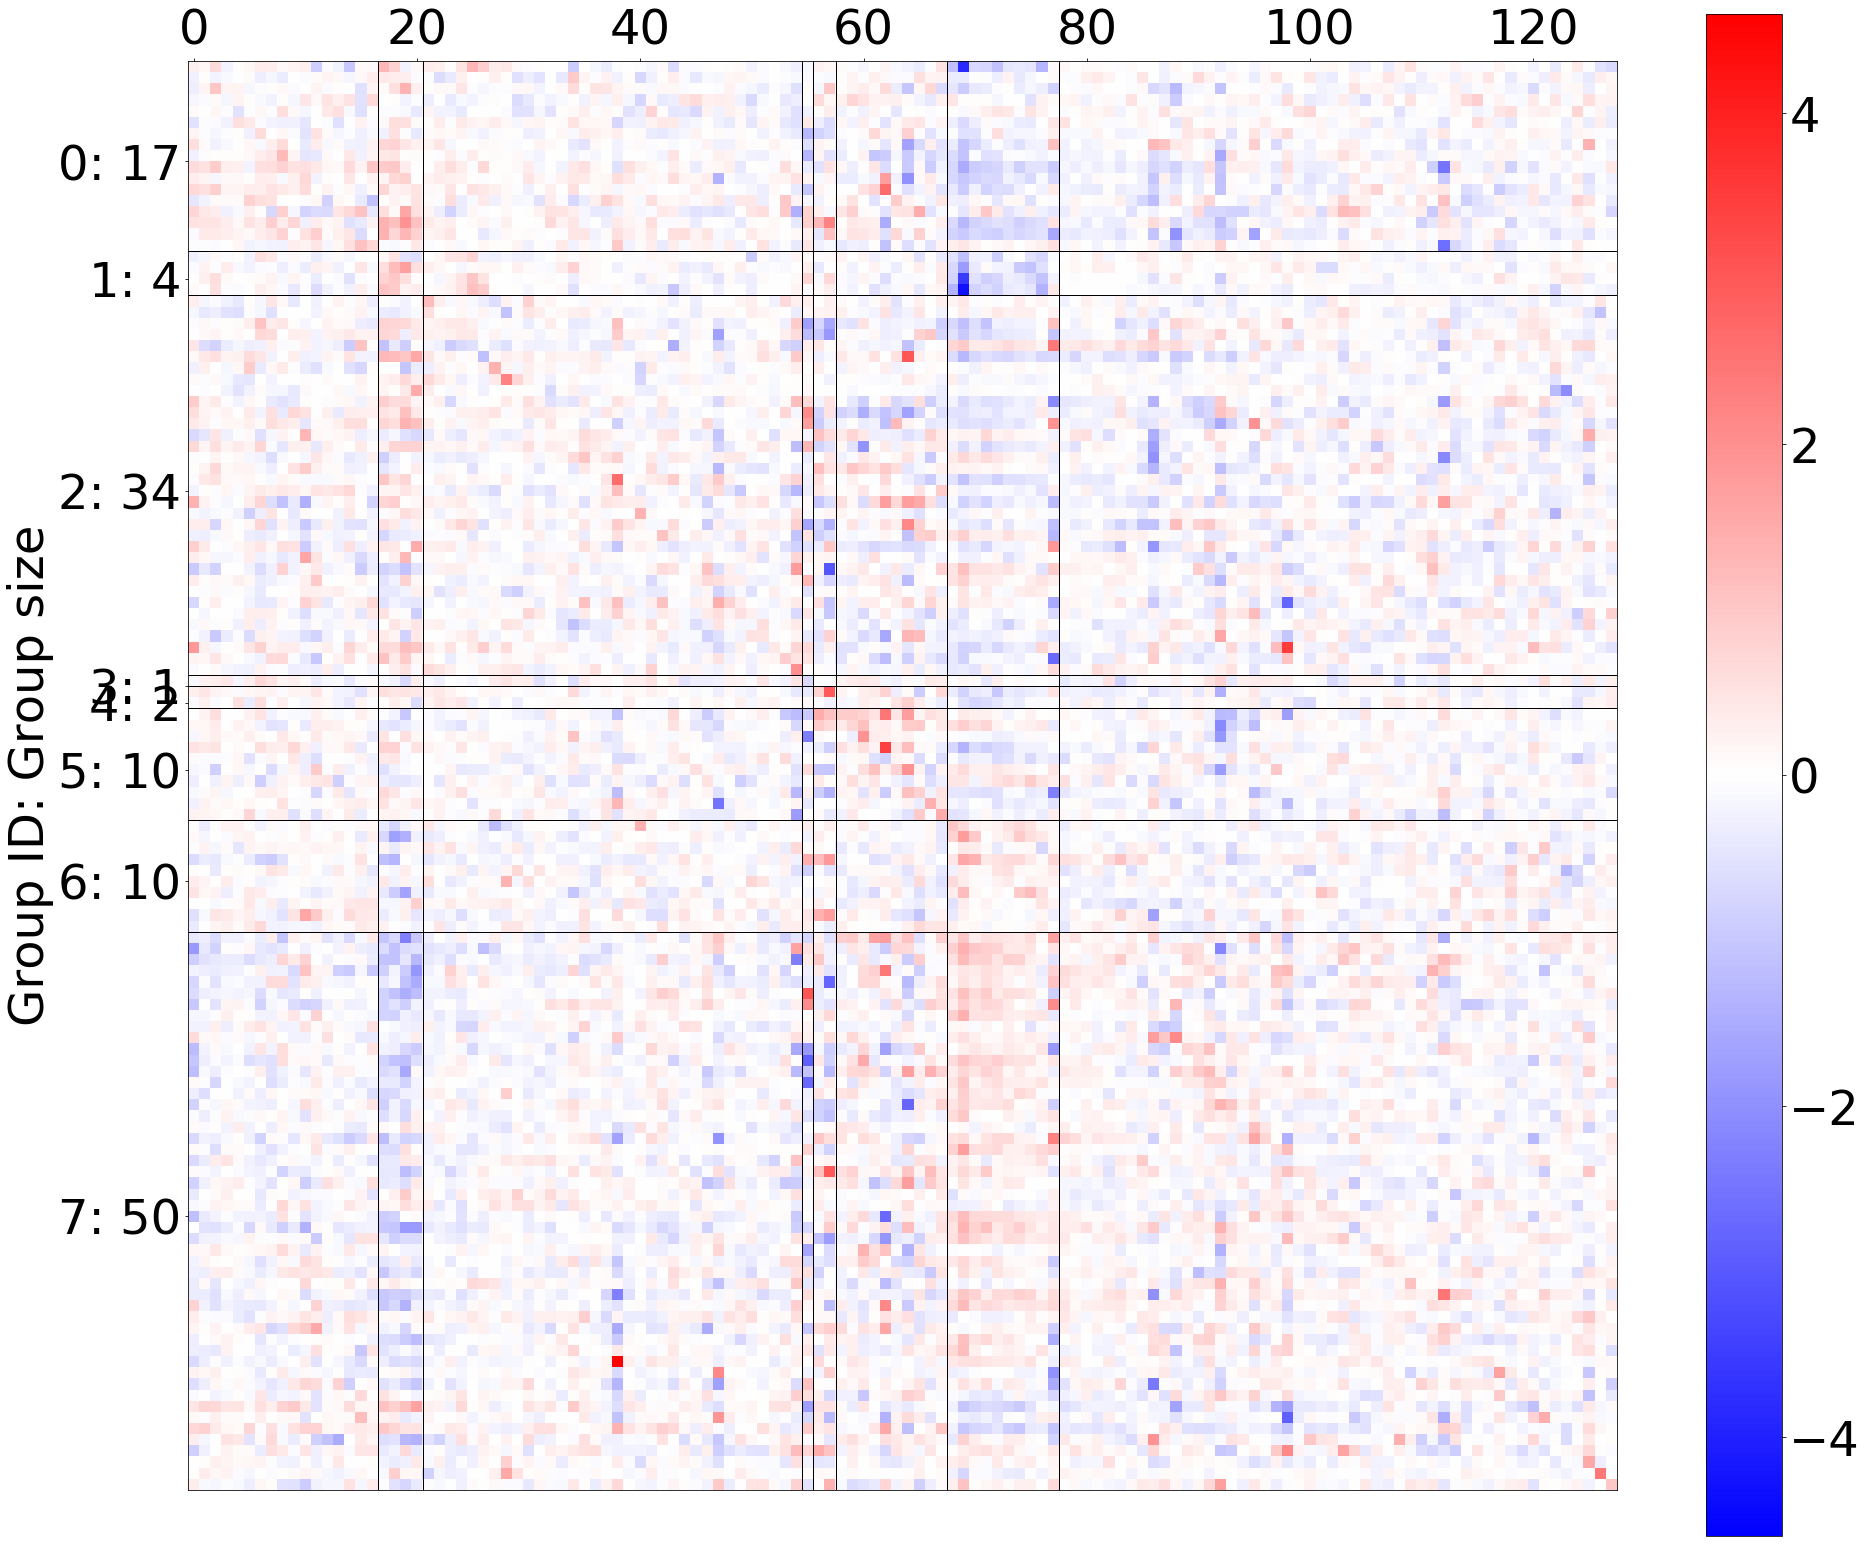

In [24]:
groups = Cell.analyze_weights(W_hn, 8)

In [25]:
for g, group in enumerate(groups):
    print(f'{g}:\t{group}')

0:	[43, 83, 89, 84, 64, 116, 110, 90, 11, 125, 55, 46, 2, 127, 67, 72, 108]
1:	[3, 117, 104, 114]
2:	[38, 76, 113, 91, 28, 68, 122, 30, 1, 42, 52, 88, 85, 77, 56, 26, 107, 80, 14, 51, 57, 115, 62, 12, 120, 45, 87, 48, 118, 21, 8, 121, 124, 126]
3:	[58]
4:	[23, 78]
5:	[47, 109, 86, 33, 95, 74, 103, 10, 94, 4]
6:	[24, 36, 59, 82, 73, 53, 6, 39, 97, 44]
7:	[0, 37, 35, 92, 65, 99, 93, 7, 9, 54, 18, 22, 27, 79, 16, 102, 105, 25, 20, 17, 106, 41, 112, 32, 40, 34, 61, 69, 5, 111, 29, 15, 75, 31, 49, 123, 13, 98, 81, 96, 19, 63, 101, 60, 50, 100, 119, 70, 66, 71]


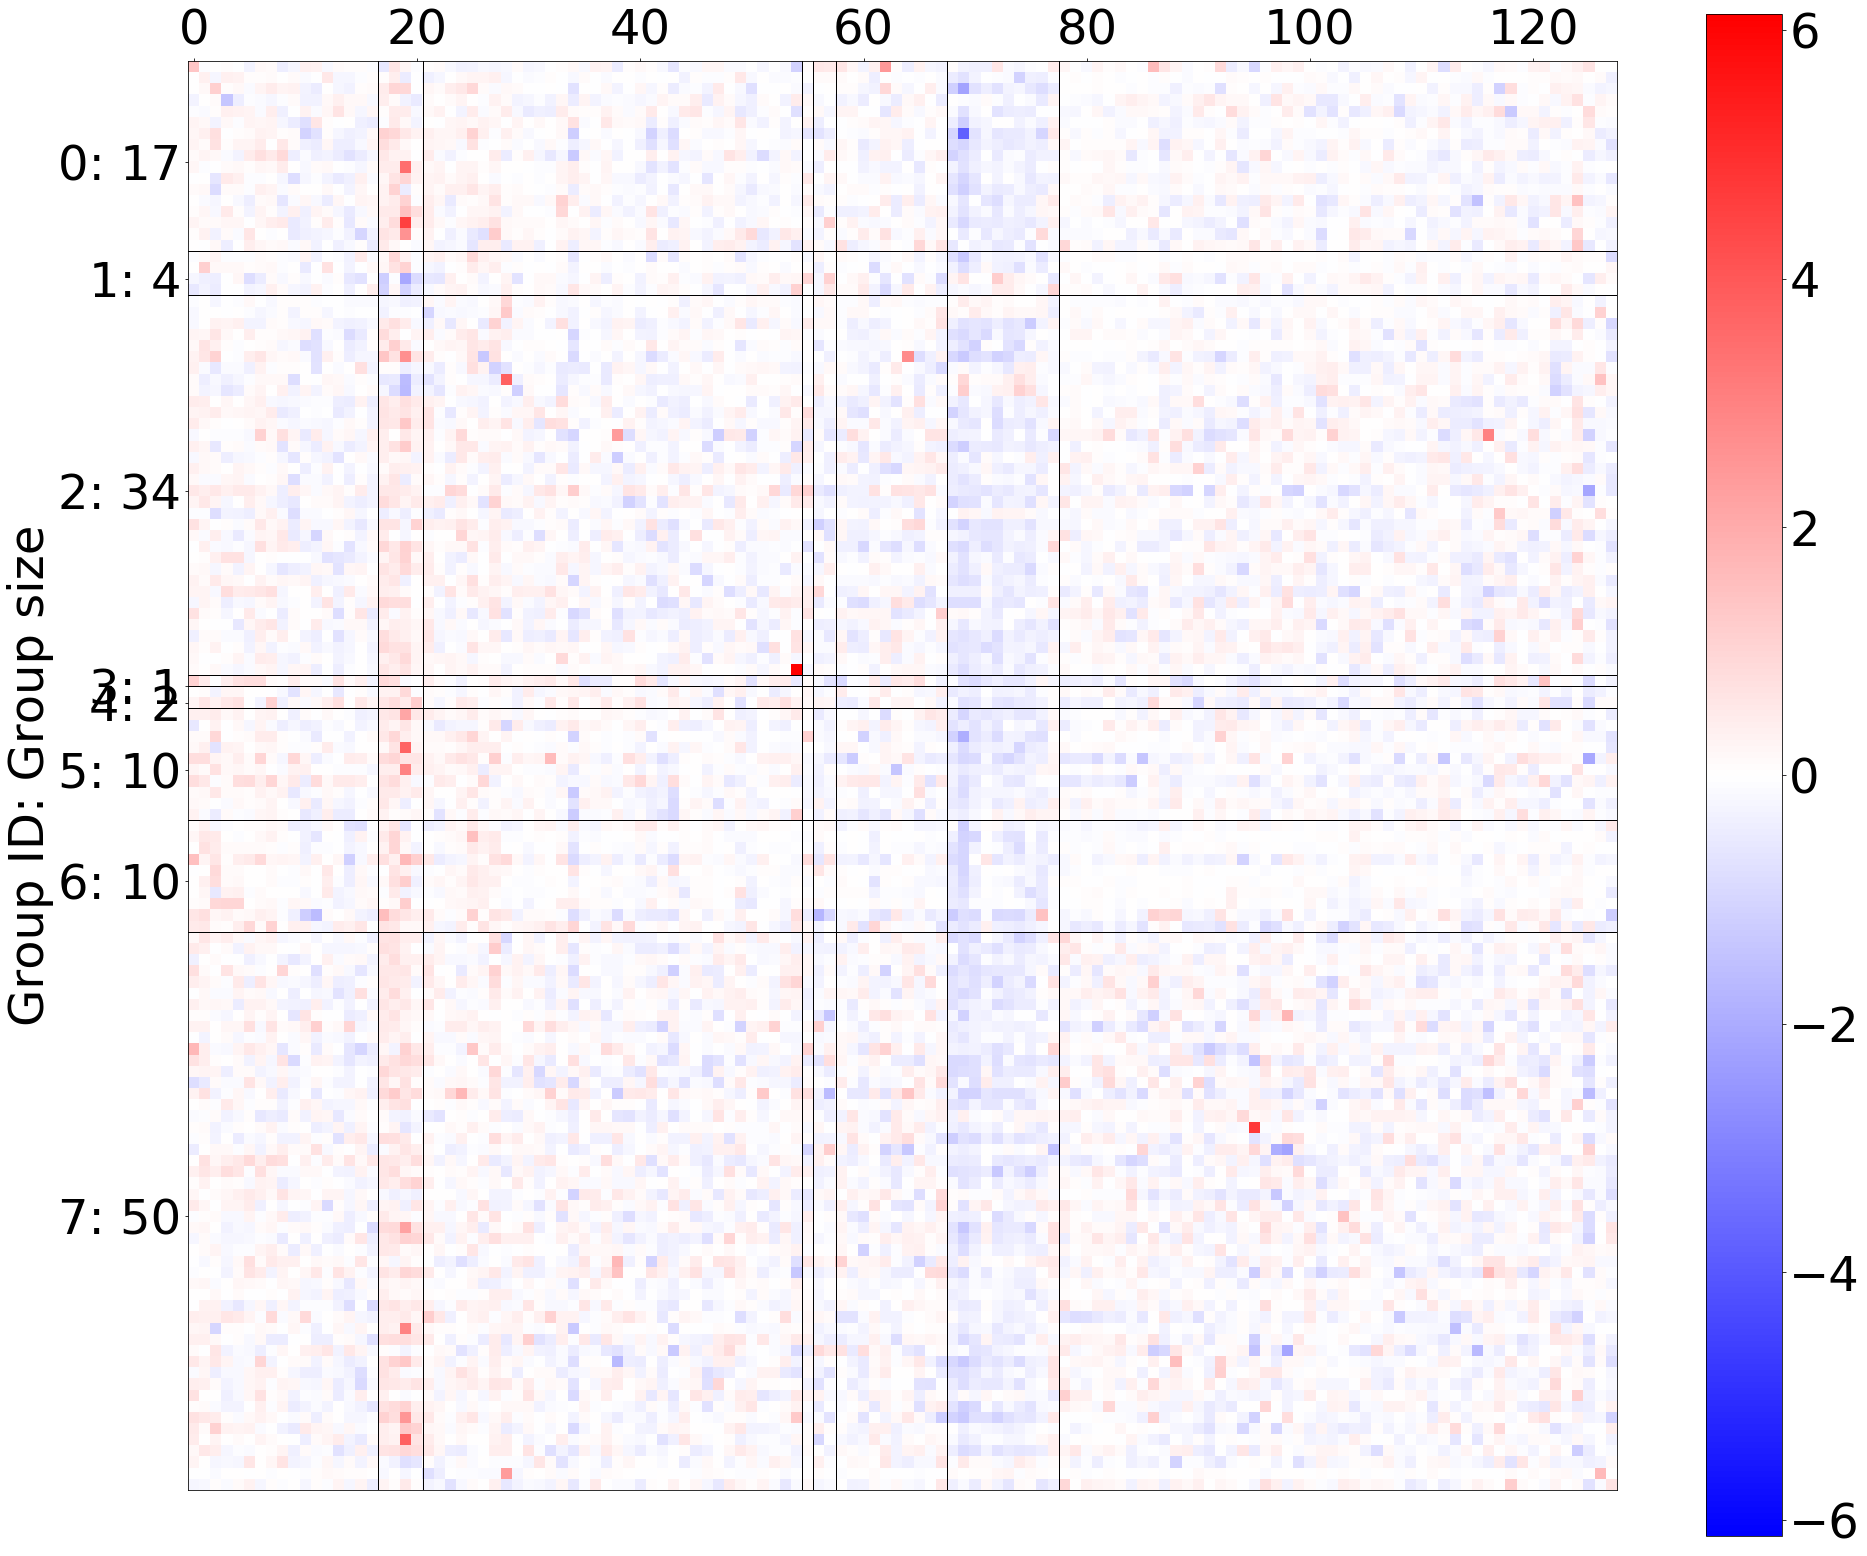

In [26]:
Cell.plot_weights(W_hz, groups)

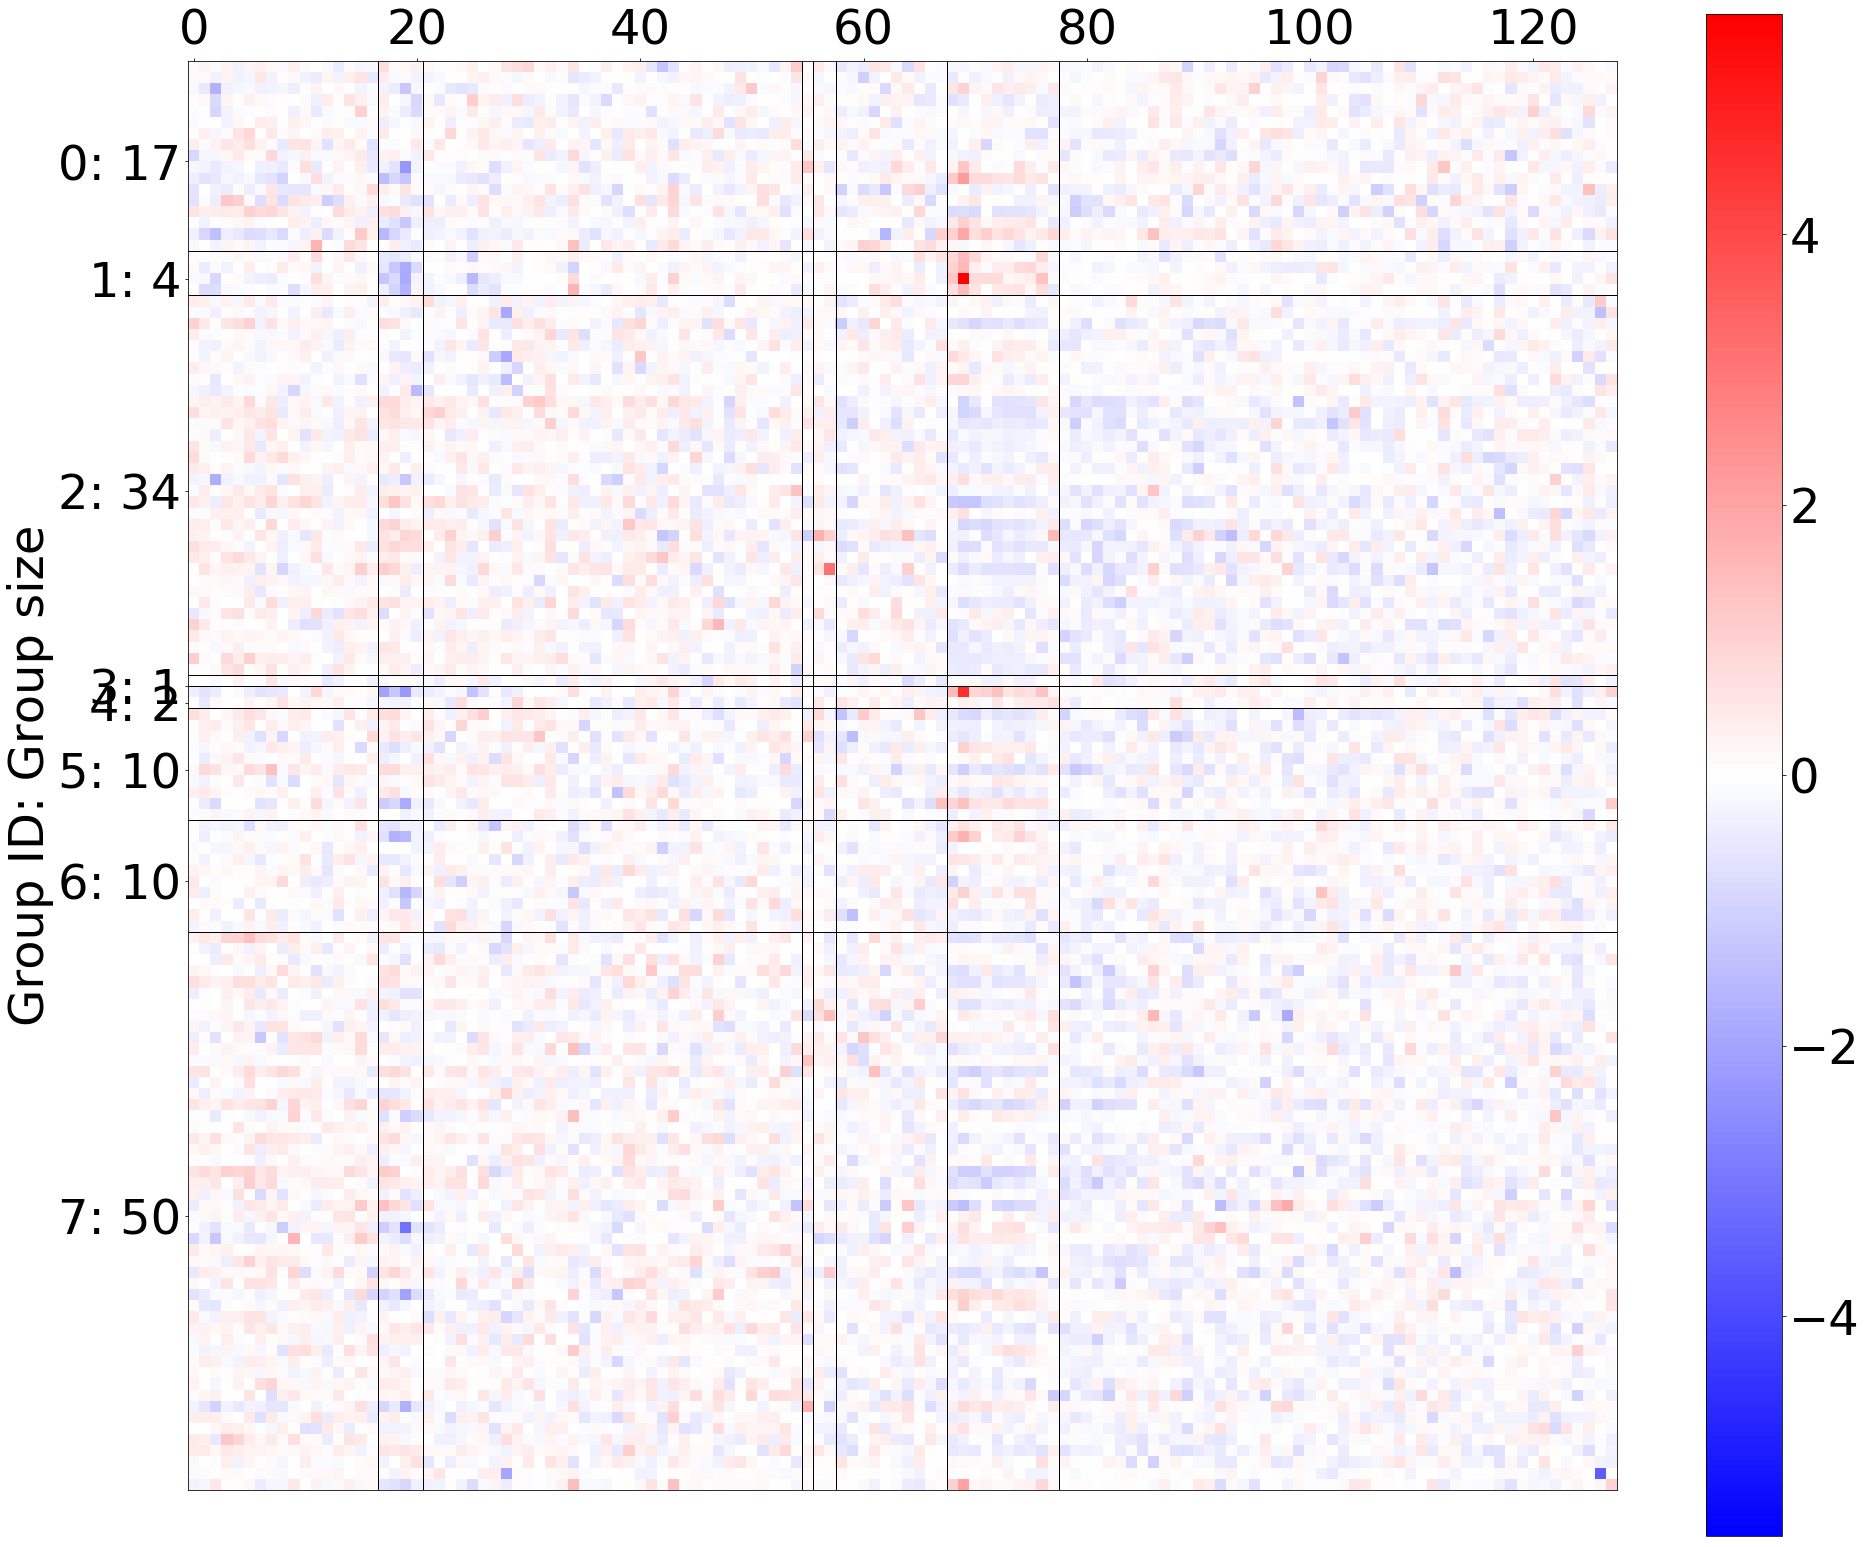

In [27]:
Cell.plot_weights(W_hr, groups)

## Classifier weight analysis

In [28]:
clf_weight = model.decoder.clf.weight.detach().numpy()
clf_weight.shape

(6618, 128)

In [29]:
print(embedder.word_list[0:4])
print(embedder.word_list[4:59])
print(embedder.word_list[59:256])

['<PAD>', '<SOS>', '<EOS>', '<UNK>']
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '心', '疼', '你', '还', '没', '挣', '脱', '思', '念', '的', '囚', '禁', '他', '在', '一', '段', '难', '忘', '远', '行', '最', '后', '却', '离', '去', '无', '力', '依', '靠', '我', '这', '里', '隔', '着', '刚', '被', '雨', '淋', '湿', '玻', '璃', '问', '了']
['到', '底', '爱', '哪', '想', '目', '地', '剩', '多', '少', '公', '累', '也', '关', '系', '可', '以', '暂', '停', '途', '中', '先', '加', '满', '勇', '气', '能', '不', '别', '让', '带', '其', '实', '真', '很', '近', '幸', '福', '相', '信', '是', '开', '往', '明', '天', '旅', '跟', '定', '次', '会', '迷', '路', '或', '伤', '昨', '否', '情', '风', '景', '转', '个', '弯', '就', '见', '踪', '影', '换', '对', '收', '集', '新', '回', '忆', '告', '诉', '哈', '腾', '云', '驾', '雾', '追', '逐', '电', '头', '十', '万', '八', '千', '火', '眼', '金', '睛', '铜', '铁', '肩', '威', '凛', '大', '圣', '齐', '说', '什', '么', '艰', '险', '磨', '怕', '鬼', '怪', '神', '仙', '扯', '如', '意', '箍', '棒', '打', '它', '覆', '翻', '强', '者', '为', '尊', '应', '英', '雄', '只', '此', '敢', '争', '腔', '热', '血', '身', '胆', '知',

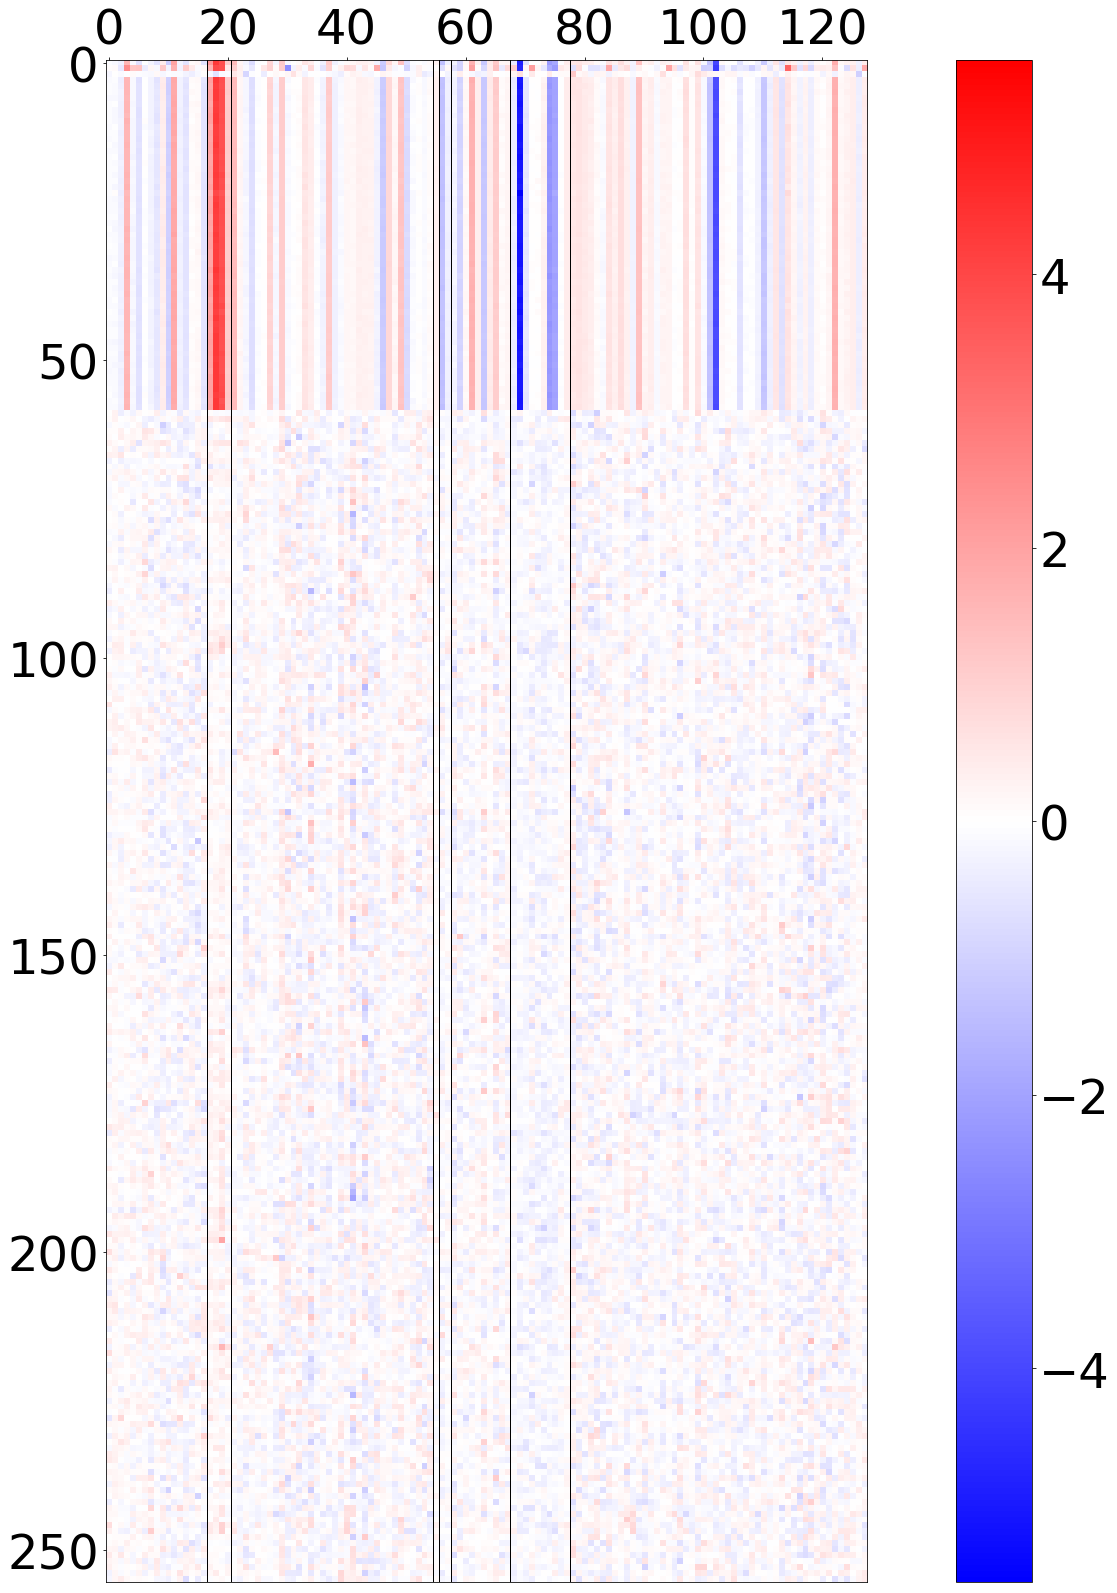

In [30]:
Cell.plot_weights(clf_weight[:256,:], groups, perm_dim=(0,1))

In [31]:
U, S, V = np.linalg.svd(clf_weight, full_matrices=False)
# clf_weight = W @ R
W = U @ np.diag(S) # (6618, 128)
R = V #(128, 128)

[428.79904   125.86876    90.76498    51.45735    35.853115   34.39052
  32.615383   29.836561   29.82       29.37431    28.432539   27.979502
  27.347183   26.872574   26.81113    26.354921   26.000113   25.777252
  25.503975   25.463854   24.72661    24.549894   24.375895   24.114586
  23.98704    23.724323   23.270113   22.960634   22.844603   22.530994
  22.204483   21.908573   21.731592   21.403759   21.207222   20.956482
  20.921534   20.690437   20.605423   20.452322   20.163202   20.085281
  19.959707   19.808819   19.684172   19.477629   19.376627   19.331516
  19.067013   18.935553   18.813414   18.720522   18.552177   18.29803
  18.270006   18.1028     18.062773   17.942133   17.852936   17.776838
  17.724602   17.526083   17.49       17.369001   17.326803   17.249512
  17.181849   17.061434   17.004745   16.818153   16.759699   16.624884
  16.613604   16.504713   16.39664    16.336761   16.216124   16.032354
  16.023764   15.944887   15.890381   15.768253   15.707631   15.6

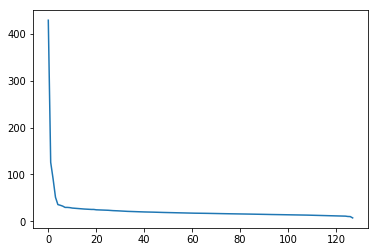

In [32]:
print(S)
plt.plot(S)

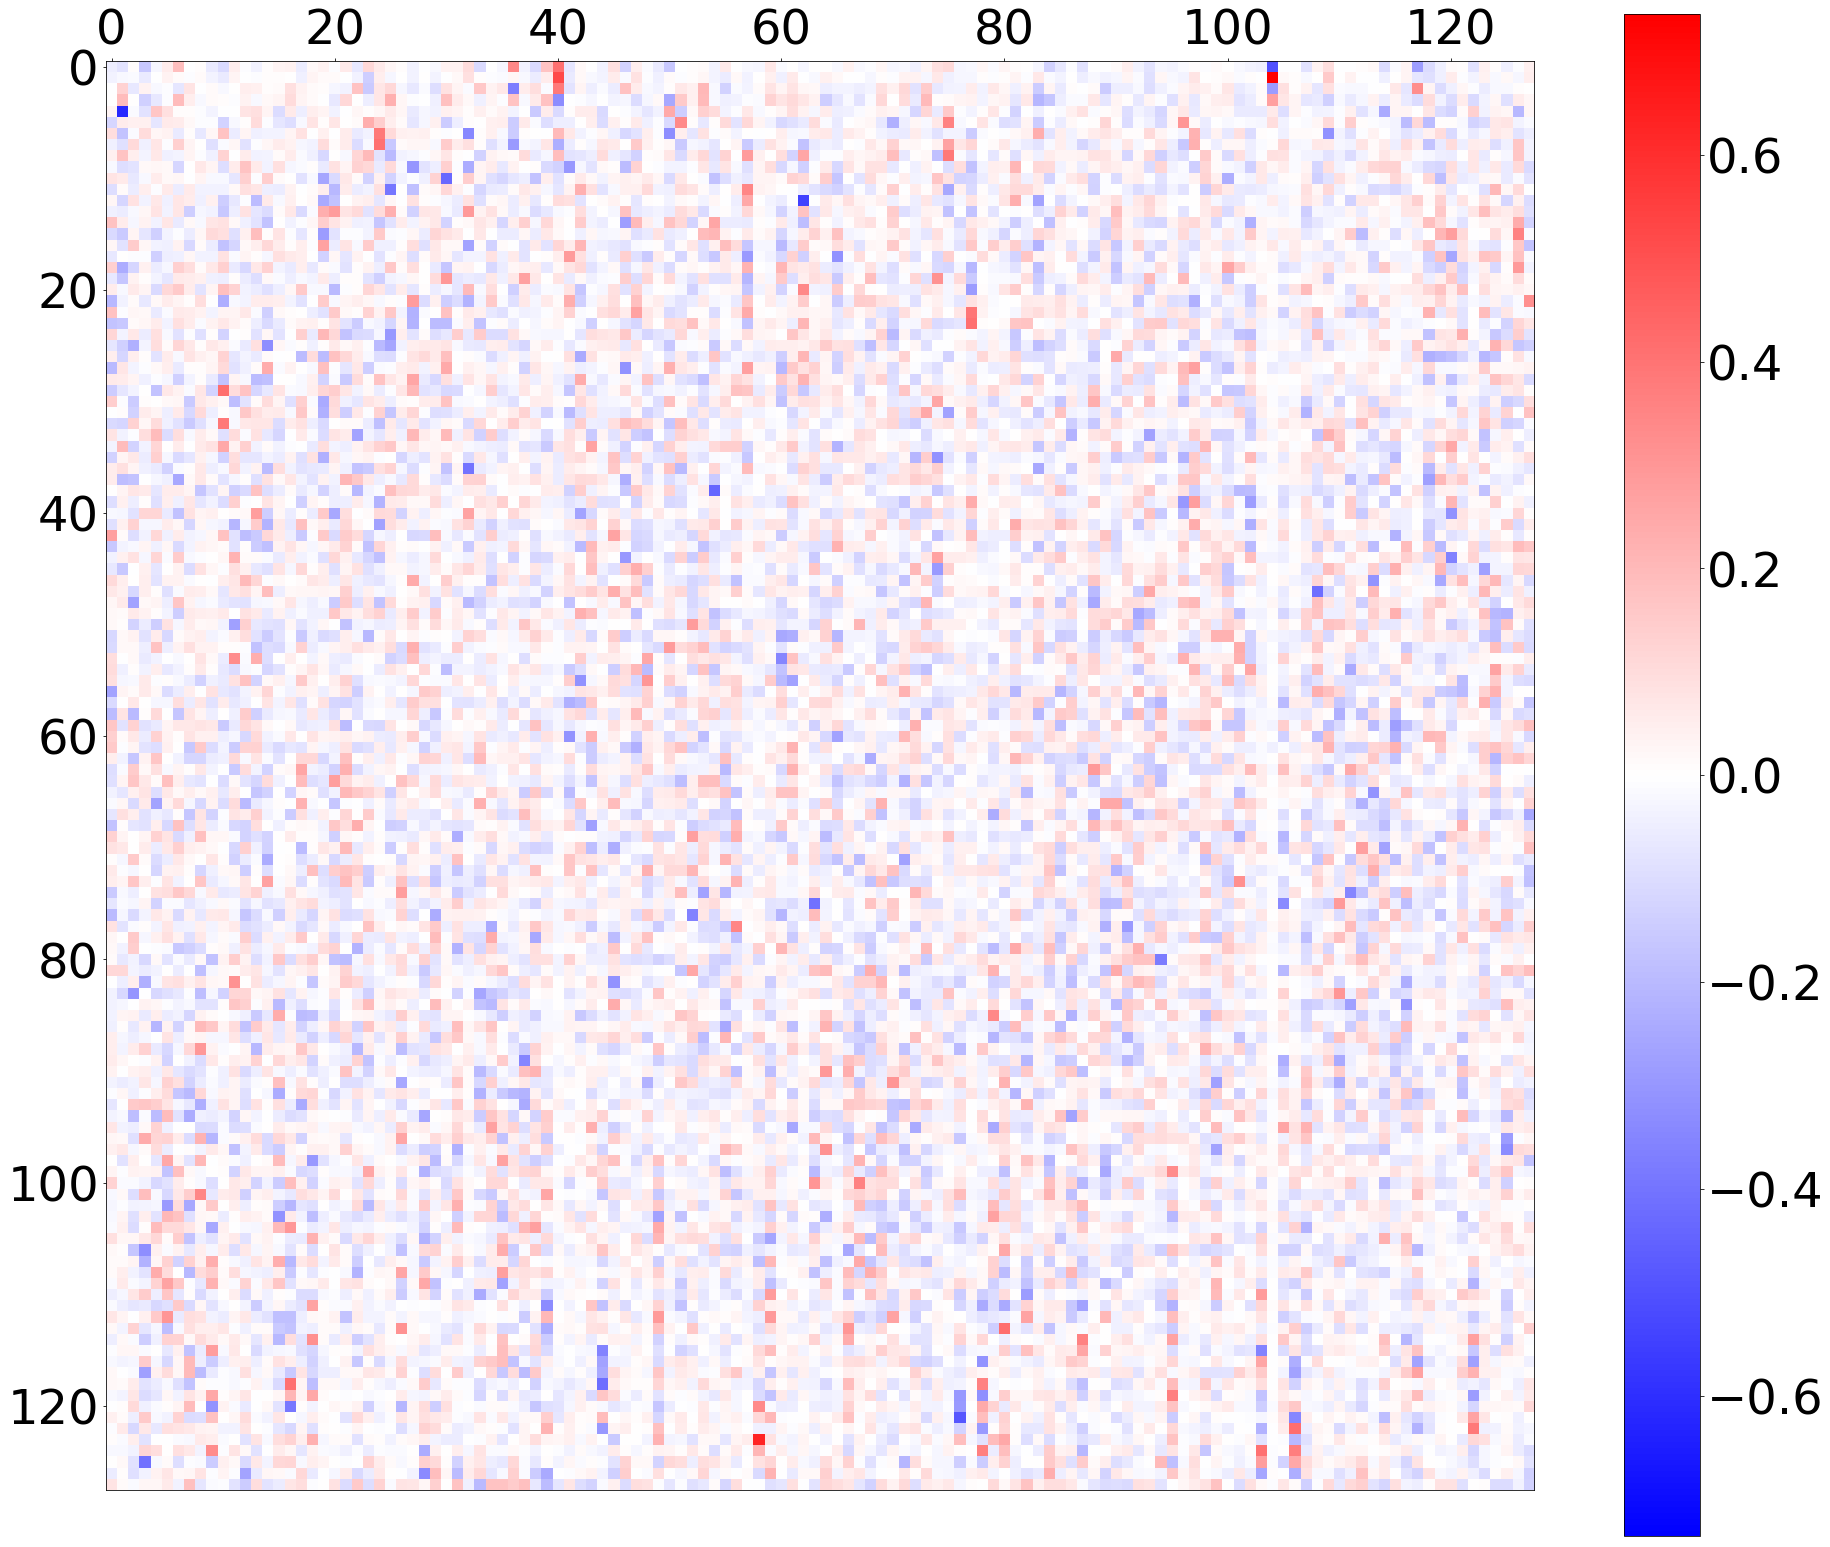

In [33]:
Cell.plot_weights(R, groups=groups, perm_dim=(0,0))

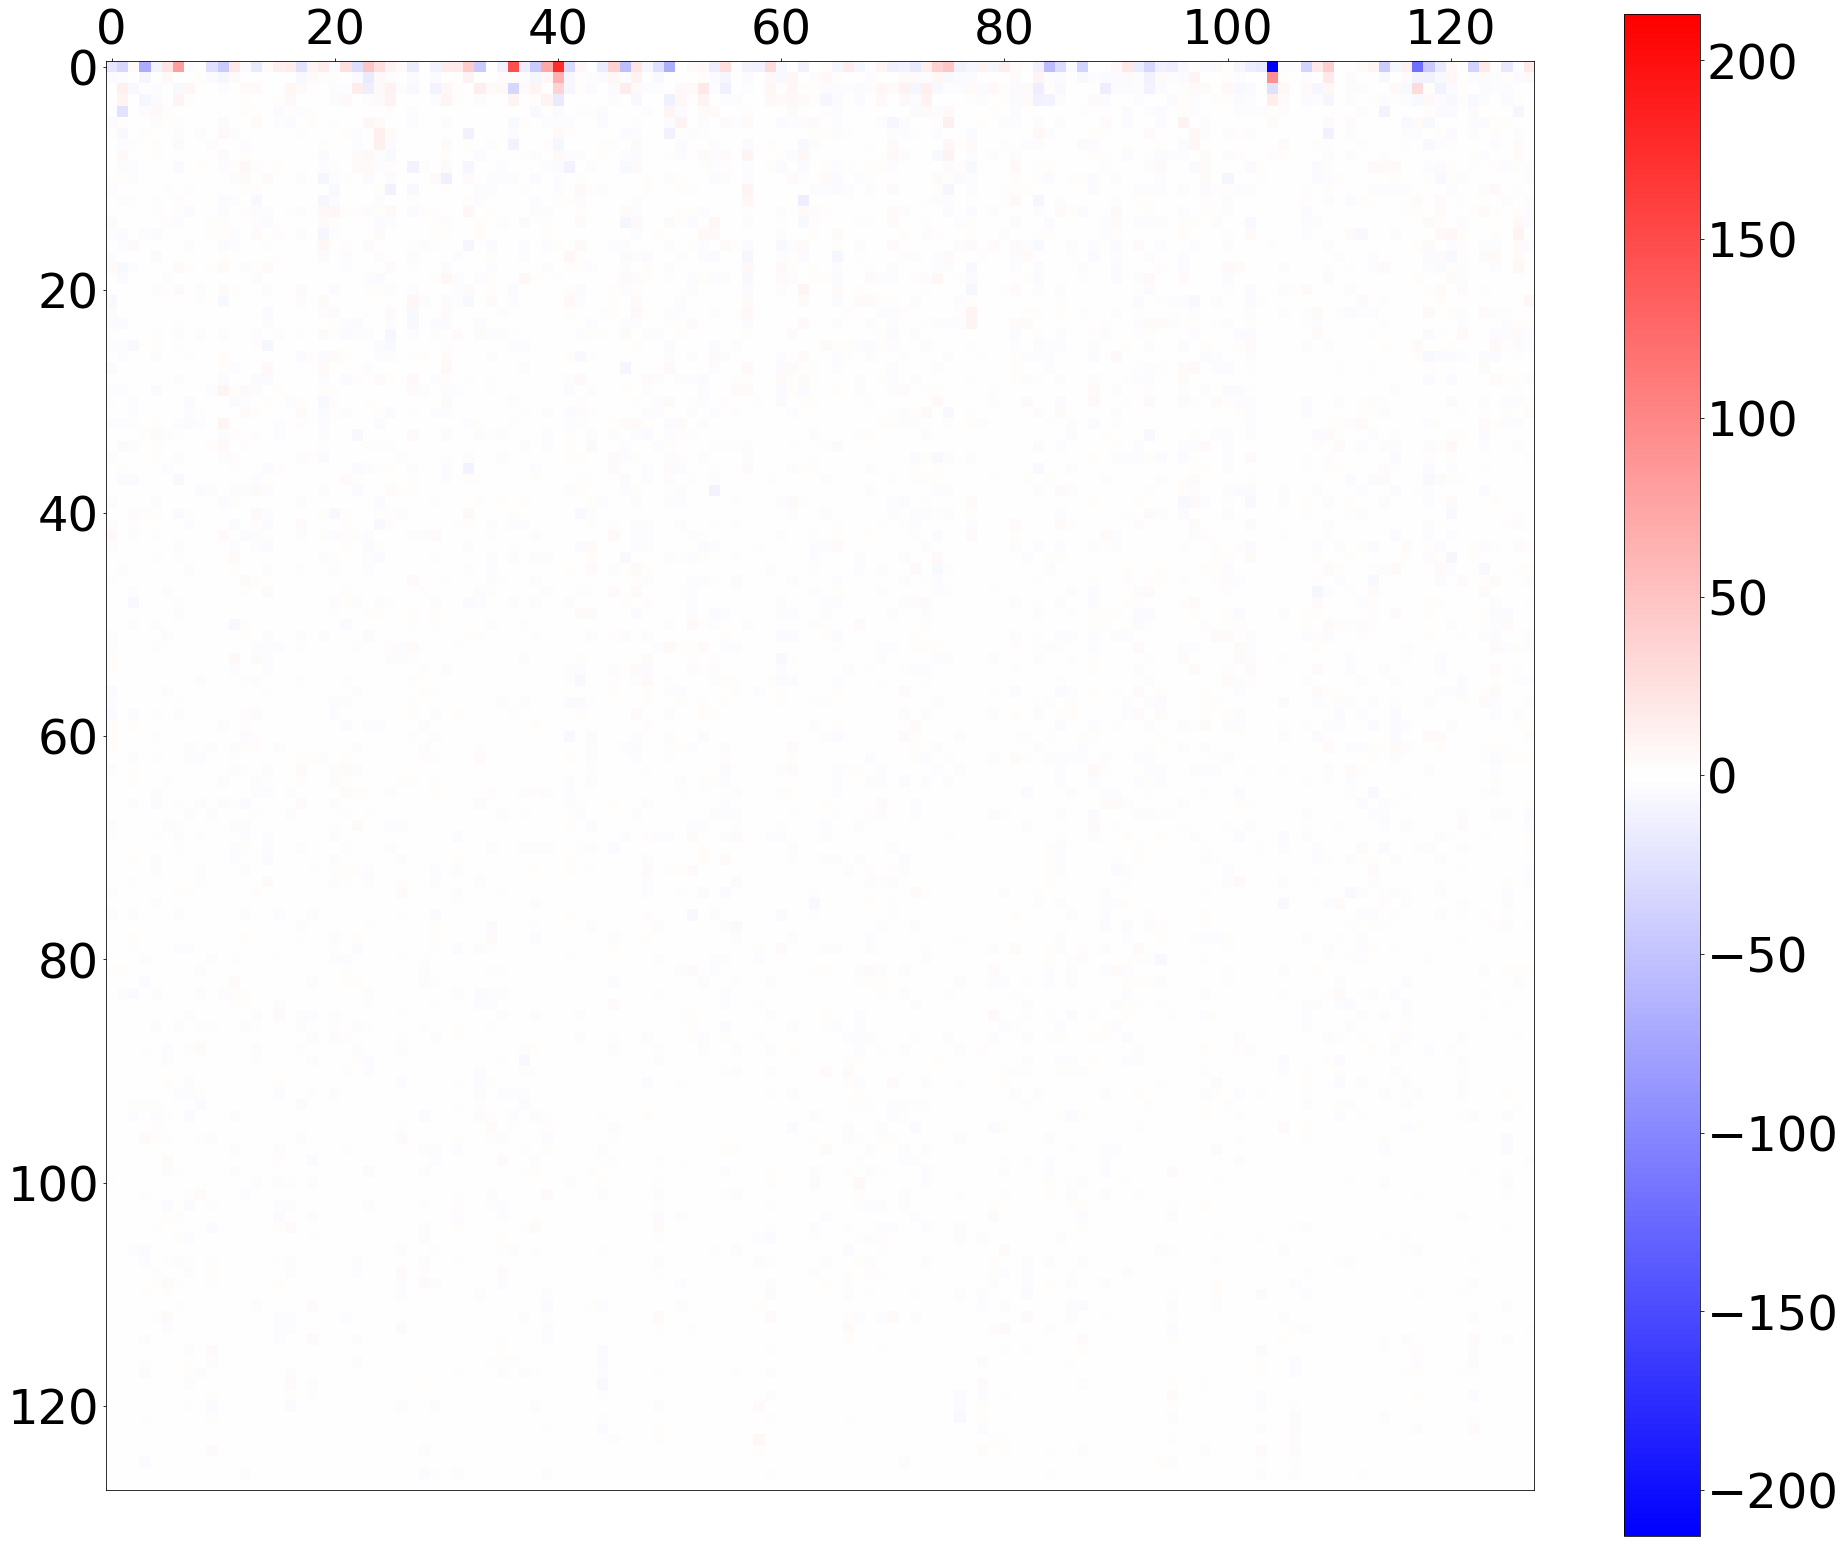

In [34]:
Cell.plot_weights(np.diag(S)@R, groups=groups, perm_dim=(0,0))

In [35]:
components = np.sum(np.abs((np.diag(S) @ R)[:3,:]), axis=0)
sorted(enumerate(components), key=lambda c: c[1], reverse=True)

[(104, 331.576),
 (40, 276.90515),
 (36, 184.18234),
 (117, 158.34967),
 (6, 88.509155),
 (39, 80.48997),
 (3, 79.149254),
 (23, 78.07395),
 (46, 72.0407),
 (50, 69.86562),
 (109, 68.459435),
 (38, 59.890766),
 (33, 59.745285),
 (84, 59.491375),
 (118, 58.040703),
 (32, 55.000984),
 (75, 54.987827),
 (10, 54.30334),
 (93, 52.10797),
 (74, 52.05805),
 (45, 49.430065),
 (114, 47.738926),
 (1, 47.728954),
 (22, 47.685688),
 (55, 45.971863),
 (41, 45.03758),
 (107, 42.459156),
 (87, 41.83479),
 (59, 41.249596),
 (122, 40.15092),
 (24, 38.916645),
 (85, 38.728043),
 (47, 35.94053),
 (49, 33.965656),
 (83, 32.705612),
 (119, 32.66163),
 (17, 32.42913),
 (9, 30.969515),
 (73, 29.795803),
 (21, 29.449976),
 (72, 29.315947),
 (53, 28.296616),
 (5, 28.288849),
 (91, 28.177238),
 (123, 27.240574),
 (27, 26.154078),
 (0, 26.081915),
 (25, 24.662502),
 (30, 24.447575),
 (11, 24.43904),
 (16, 24.282219),
 (108, 24.25102),
 (127, 23.702368),
 (71, 23.316105),
 (116, 23.198002),
 (125, 22.885632),
 (3

## Implement GRU Cell to collect cell states while inferencing

In [36]:
import torch.nn.functional as F

def Deconstruction(model,x,x_len):
    
    # Encoder 
    encoder_hiddens, context = model.encoder(x,x_len)
    
    # Decoder
    decoder_hidden = context.squeeze(0)
    
    # Collection signal
    decoder_outputs = []
    decoder_hiddens = []
    decoder_resetGates = []
    decoder_updateGates = []
    decoder_newGates = []
    
    for iteration in range(15):
        
        # GRU Cell
        gru = model.decoder.cell
        
        U_h = F.linear(decoder_hidden, gru.weight_hh)
        Ur_h, Uz_h, Un_h = U_h.chunk(3, 1)
        reset_gate = torch.sigmoid(Ur_h)
        update_gate = torch.sigmoid(Uz_h)
        new_gate  = torch.tanh(reset_gate * Un_h)
        decoder_hidden = new_gate + update_gate * (decoder_hidden - new_gate)
        
        # Classifier
        clf_output = model.decoder.clf(decoder_hidden)
        decoder_output = model.decoder.log_softmax(clf_output)
        
        # mask specific cells
        mask = torch.ones(128)
        for cell in disabled_cells:
            mask[cell] = 0
        decoder_hidden *= mask
        
        # save states
        decoder_resetGates.append(reset_gate)
        decoder_updateGates.append(update_gate)
        decoder_newGates.append(new_gate)
        decoder_outputs.append(decoder_output)            
        decoder_hiddens.append(decoder_hidden)
                                                   
        if torch.all(decoder_output.argmax(-1)==EOS) == True:
            break
            
    outputs = torch.stack(decoder_outputs,dim=2)             # (b,6xxx,s)
    
    gru_info = {
        'hiddens':torch.stack(decoder_hiddens,dim=2),             # (b,128,s)
        'resetgates':torch.stack(decoder_resetGates,dim=2),       # (b,128,s)
        'updategates':torch.stack(decoder_updateGates,dim=2),     # (b,128,s)
        'newgates':torch.stack(decoder_newGates,dim=2)            # (b,128,s)
    }
    
    return outputs, gru_info

## Generate certain condition valid datas ( by designated word / position filter )

In [37]:
def get_certain_set(pos, word, show=False):
    certain_set = []

    designated_POS = pos
    designated_word = word

    for sent in random.sample(corpus, k=128):

        control_signal = [str(designated_POS) , designated_word]

        data = ['<SOS>'] + sent + ['<EOS>'] + control_signal

        if show:
            print(data)

        certain_set.append(data)

    dataset_certain = TestDataset(certain_set)
    return dataset_certain

## Prediction certain condition data

In [38]:
def predict(dataset):
    dataloader = DataLoader(dataset=dataset,
                            batch_size=128,
                            shuffle=False,
                            collate_fn=dataset.collate_fn,
                            num_workers=0)

    predictions = []
    trange = tqdm(dataloader, total=len(dataloader))

    for x,x_len in trange:

        x = x.to(device)

        outputs, gru_info = Deconstruction(model,x,x_len)

        for pred in outputs.cpu().detach().numpy().argmax(1):
            predictions.append(pred)
    return predictions, gru_info

In [39]:
def untokenize_output(dataset, predictions):
    # Process multi-EOS tokens
    predictions_set = []
    for p in predictions:
        p = list(p)
        if EOS in p:
            p = p[:p.index(EOS)+1]
        else:
            p.append(EOS)
        predictions_set.append(embedder.unTokenize(p))

    for sent_id in range(len(dataset)):
        sent_in = ''.join(dataset[sent_id])
        sent_pred = ''.join(predictions_set[sent_id])
        print(f'input:\t{sent_in}\npred:\t{sent_pred}\n')

# Cell classification

In [40]:
import Cell

## Get testing set

In [41]:
# disabled_cells = {*(groups[7][:20])}
disabled_cells = {}

In [42]:
# certain_set = get_certain_set(8, Cell.draw('张朦胧的话只是无聊的暗号'))
certain_set = get_certain_set(5, '女')

In [43]:
import numpy as np

predictions, gru_info = predict(certain_set)

gates = {'input': gru_info['updategates'].detach().cpu().numpy(),
         'reset': gru_info['resetgates'].detach().cpu().numpy(),
         'new': gru_info['newgates'].detach().cpu().numpy(),
         'hidden': gru_info['hiddens'].detach().cpu().numpy()} # (b,128,s)

gates_avg = {}
gates_std = {}
for key, value in gates.items():
    gates_avg[key] = value.mean(0) # (128,s)
    gates_std[key] = value.std(0) # (128,s)

output_len = gates['input'].shape[2]
print(output_len)


15


In [44]:
untokenize_output(certain_set, predictions)

input:	<SOS>你想出街我做你好司机<EOS>5女
pred:	<SOS>厚篝少宽少少少系少少女女<EOS>

input:	<SOS>我们变成了世上最熟悉的陌生人<EOS>5女
pred:	<SOS>让幕少捧女<EOS>

input:	<SOS>那些你想要的承诺是否依然在这<EOS>5女
pred:	<SOS>合系少少少少少系少少女女<EOS>

input:	<SOS>在不知不觉中泪已成行<EOS>5女
pred:	<SOS>让管少少女女<EOS>

input:	<SOS>现在我唱这首歌<EOS>5女
pred:	<SOS>让幕少痛女女<EOS>

input:	<SOS>我把心情谈的那样赤裸<EOS>5女
pred:	<SOS>让篝少少少少少系少痛女女<EOS>

input:	<SOS>我在为你默默地憔悴<EOS>5女
pred:	<SOS>合听少幕少少少系系少女女<EOS>

input:	<SOS>哪怕离家这么遥远这么久<EOS>5女
pred:	<SOS>让幕少捧女<EOS>

input:	<SOS>森林的动物都走出山谷<EOS>5女
pred:	<SOS>幕幕档捧女<EOS>

input:	<SOS>窗台上放的宝特瓶花盆<EOS>5女
pred:	<SOS>让管少捧女<EOS>

input:	<SOS>心甘情愿被它麻醉<EOS>5女
pred:	<SOS>让篝少少卧少少系系痛女女<EOS>

input:	<SOS>没有我的岁月里<EOS>5女
pred:	<SOS>青女東圈少少少少管痛女女<EOS>

input:	<SOS>录音师李天野<EOS>5女
pred:	<SOS>让幕少捧女<EOS>

input:	<SOS>那个梦还在心底<EOS>5女
pred:	<SOS>让管少少少少少少少少少女<EOS>

input:	<SOS>默默把你想我的姑娘<EOS>5女
pred:	<SOS>让系少少少少少少少少女女<EOS>

input:	<SOS>蓝蓝地<EOS>5女
pred:	<SOS>让头少少女<EOS>

input:	<SOS>李炜庞龙北京祝福你黄品源苗圃城墙上聊同一个话题<EOS>5女
pred:	<SOS>漫汤风卧卧卧风风档捧女<EOS>

input:	<SOS>往前走吧去找幸福的人<EOS>5女
pred:	<

## Plot groups

input--------------------
cells: [3, 104, 114, 117]


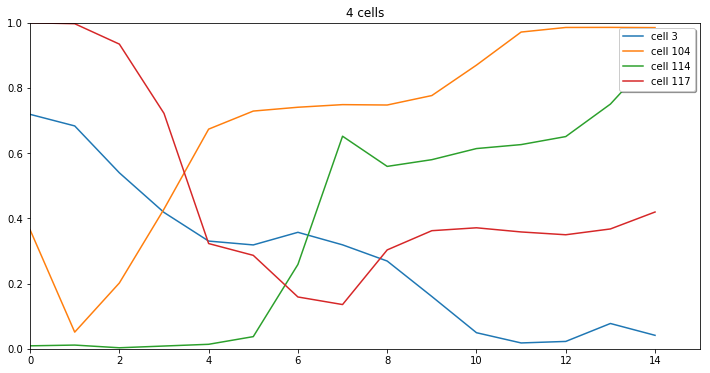

cells: [3, 104, 114, 117]


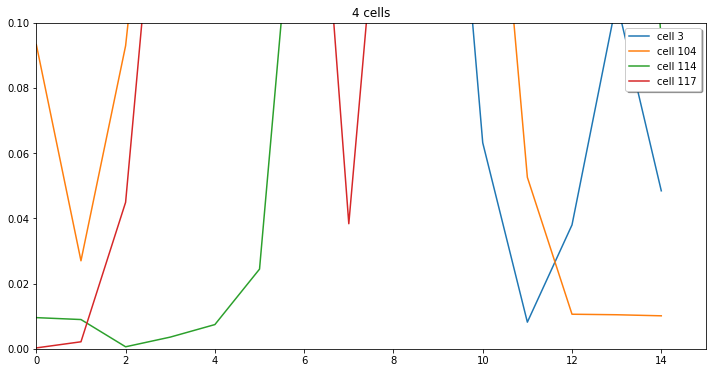

new--------------------
cells: [3, 104, 114, 117]


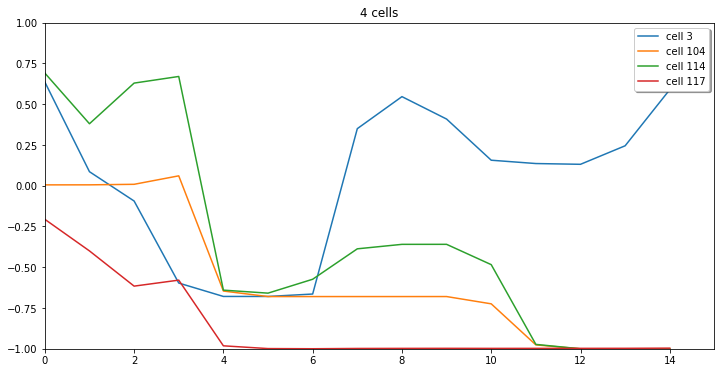

cells: [3, 104, 114, 117]


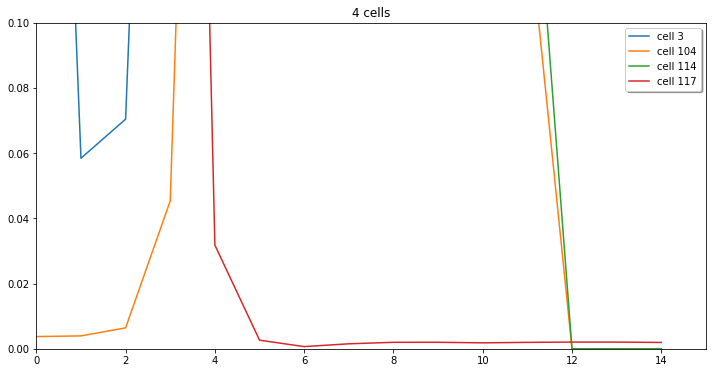

reset--------------------
cells: [3, 104, 114, 117]


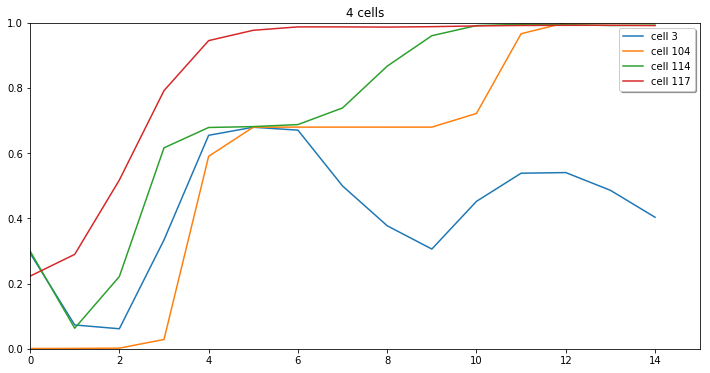

cells: [3, 104, 114, 117]


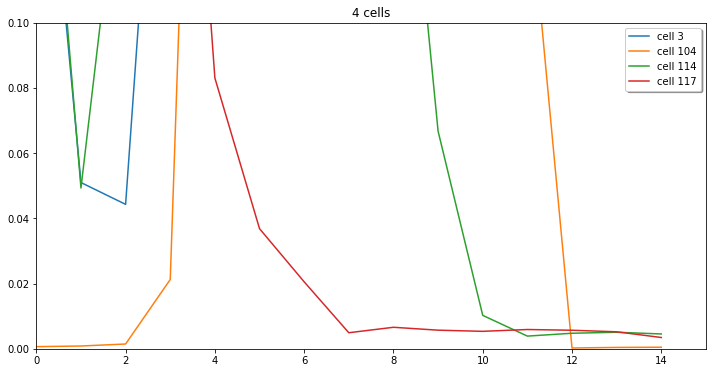

hidden--------------------
cells: [3, 104, 114, 117]


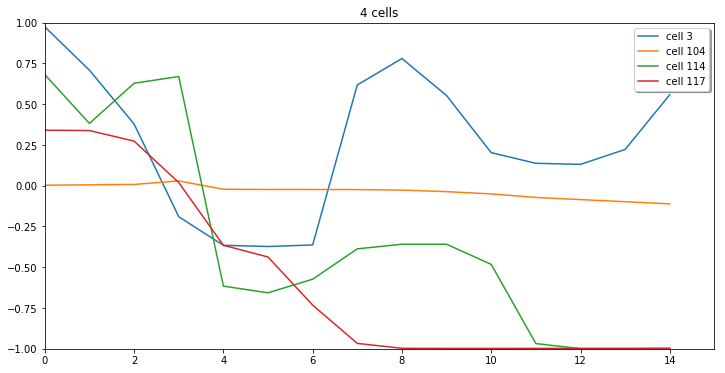

cells: [3, 104, 114, 117]


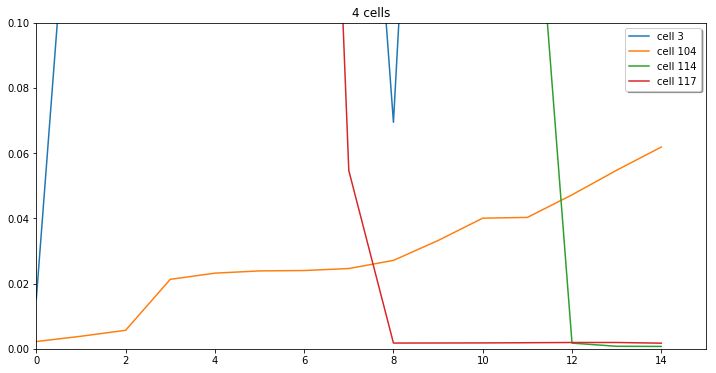

In [45]:
n = 1
print('input--------------------')
Cell.plot(gates_avg['input'], picked=groups[n], show_legend=True)
Cell.plot(gates_std['input'], picked=groups[n], show_legend=True, ylim=(0,0.1))
print('new--------------------')
Cell.plot(gates_avg['new'], picked=groups[n], show_legend=True, ylim=(-1,1))
Cell.plot(gates_std['new'], picked=groups[n], show_legend=True, ylim=(0,0.1))
print('reset--------------------')
Cell.plot(gates_avg['reset'], picked=groups[n], show_legend=True)
Cell.plot(gates_std['reset'], picked=groups[n], show_legend=True, ylim=(0,0.1))
print('hidden--------------------')
Cell.plot(gates_avg['hidden'], picked=groups[n], show_legend=True, ylim=(-1,1))
Cell.plot(gates_std['hidden'], picked=groups[n], show_legend=True, ylim=(0,0.1))

## Analyze group distribution

In [46]:
class Group_analyzer:
    def __init__(self, groups):
        group_dict = {}
        for g, group in enumerate(groups):
            for cell in group:
                group_dict[cell] = g
        self.groups = groups
        self.group_dict = group_dict
    
    def analyze_lists(self, lists):
        list_all = []
        for i, cells in enumerate(lists):
            print(f'{i}: -------------')
            print('\t'.join(['cells: ']+[str(cell) for cell in cells]))
            print('\t'.join(['group: ']+[str(self.group_dict[cell]) for cell in cells]))
            list_all += (cells)
        print('=============')
        print(f'Total: {len(list_all)} cells')
        print('=============')
        set_all = set(list_all)
        print('\t'.join(['groups:']+[str(g) for g in range(len(groups))]))
        print('\t'.join(['count: ']+[str(len(list_all)-len(set_all-set(group))) for group in self.groups]))
        print('=============')
        return list_all
        
ga = Group_analyzer(groups)

In [47]:
cd = [[71, 82, 98, 119], [73, 39, 90, 110], [21, 33, 91], [59], [117], [24], [36], [97]]
cd_all = ga.analyze_lists(cd)

0: -------------
cells: 	71	82	98	119
group: 	7	6	7	7
1: -------------
cells: 	73	39	90	110
group: 	6	6	0	0
2: -------------
cells: 	21	33	91
group: 	2	5	2
3: -------------
cells: 	59
group: 	6
4: -------------
cells: 	117
group: 	1
5: -------------
cells: 	24
group: 	6
6: -------------
cells: 	36
group: 	6
7: -------------
cells: 	97
group: 	6
Total: 16 cells
groups:	0	1	2	3	4	5	6	7
count: 	2	1	2	0	0	1	7	3


In [48]:
sem = {0, 10, 14, 21, 25, 27, 28, 34, 35, 42, 50, 52, 54, 55, 60, 61, 62, 63, 67, 69, 77, 79, 81, 92, 98, 99, 101, 102, 108, 109, 110, 112, 113, 115, 118, 119, 123, 124}
sem_all = ga.analyze_lists([list(sem)])

0: -------------
cells: 	0	10	14	21	25	27	28	34	35	42	50	52	54	55	60	61	62	63	67	69	77	79	81	92	98	99	101	102	108	109	110	112	113	115	118	119	123	124
group: 	7	5	2	2	7	7	2	7	7	2	7	2	7	0	7	7	2	7	0	7	2	7	7	7	7	7	7	7	0	5	0	7	2	2	2	7	7	2
Total: 38 cells
groups:	0	1	2	3	4	5	6	7
count: 	4	0	11	0	0	2	0	21


## Pick cells matching some curves

In [49]:
# picked = Cell.pick(gates_avg['input'],
#     [1,1,1,1,1,1,0],
#     [1,1,1,1,1,3,3],
#     lambda d: d<0.3,# and d>0.3,
#     max_diff=0.9,
# #     include=included,
# )

## Plot selected cells

types: {
'count_down': {33, 98, 97, 36, 71, 39, 73, 59, 110, 82, 21, 117, 119, 24, 90, 91},
'semantic': {0, 10, 14, 21, 25, 27, 28, 34, 35, 42, 50, 52, 54, 55, 60, 61, 62, 63, 67, 69, 77, 79, 81, 92, 98, 99, 101, 102, 108, 109, 110, 112, 113, 115, 118, 119, 123, 124},
}
cells: [1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 15, 16, 17, 18, 19, 20, 22, 23, 26, 29, 30, 31, 32, 37, 38, 40, 41, 43, 44, 45, 46, 47, 48, 49, 51, 53, 56, 57, 58, 64, 65, 66, 68, 70, 72, 74, 75, 76, 78, 80, 83, 84, 85, 86, 87, 88, 89, 93, 94, 95, 96, 100, 103, 104, 105, 106, 107, 111, 114, 116, 120, 121, 122, 125, 126, 127]


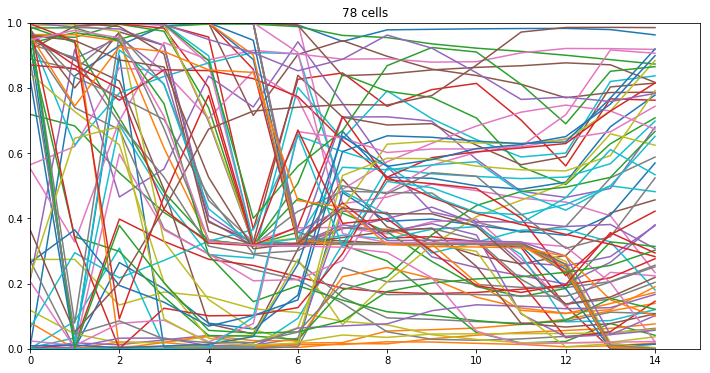

In [50]:
cell_types = {
#     'EOS': {9, 44, 49, 58, 78, 87, 106},
#     'designated': {10, 15, 19, 47, 57, 60, 62, 82},
#     'large': {35, 36, 104},
#     'test': {4, 7, 10, 15, 18, 19, 24, 47, 50, 57, 60, 62, 67, 68, 77, 82, 96, 116},
    'count_down': set(cd_all),
    'semantic': set(sem_all),
}

# cell_types['xxx10'] = picked

included = set(range(len(gates_avg['input'])))
print('types: {')
for key, value in cell_types.items():
    print(f"'{key}': {value},")
    included -= value
print('}')
Cell.plot(gates_avg['input'], picked=included)

count_down:----------------------
cells: [21, 24, 33, 36, 39, 59, 71, 73, 82, 90, 91, 97, 98, 110, 117, 119]


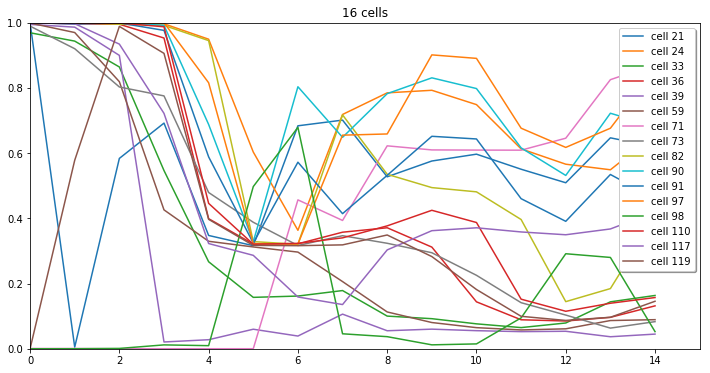

cells: [21, 24, 33, 36, 39, 59, 71, 73, 82, 90, 91, 97, 98, 110, 117, 119]


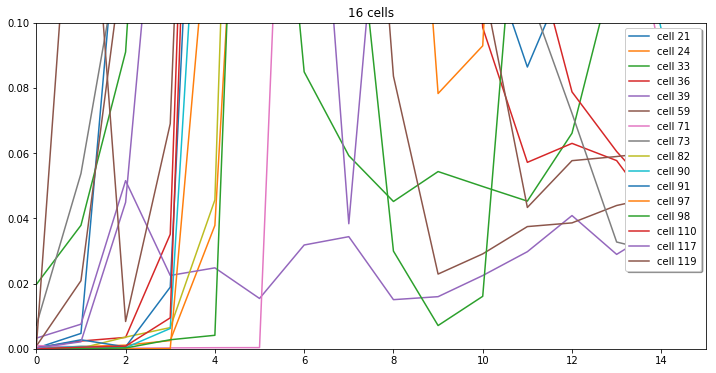

semantic:----------------------
cells: [0, 10, 14, 21, 25, 27, 28, 34, 35, 42, 50, 52, 54, 55, 60, 61, 62, 63, 67, 69, 77, 79, 81, 92, 98, 99, 101, 102, 108, 109, 110, 112, 113, 115, 118, 119, 123, 124]


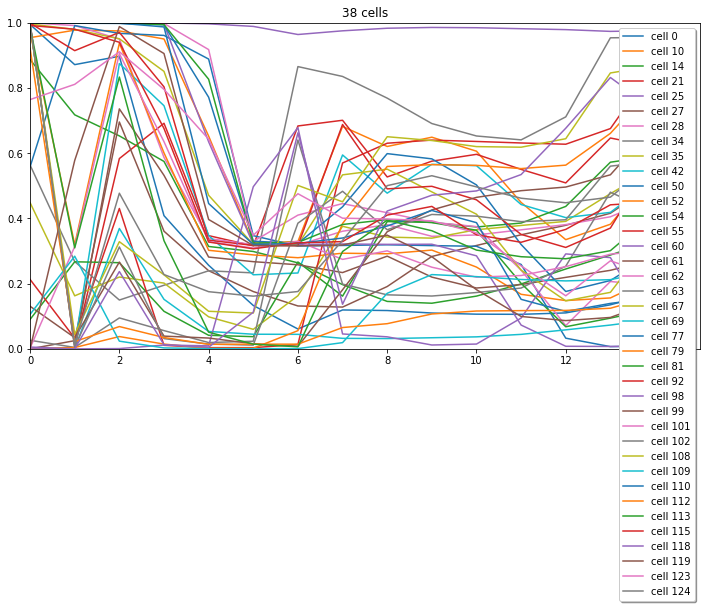

cells: [0, 10, 14, 21, 25, 27, 28, 34, 35, 42, 50, 52, 54, 55, 60, 61, 62, 63, 67, 69, 77, 79, 81, 92, 98, 99, 101, 102, 108, 109, 110, 112, 113, 115, 118, 119, 123, 124]


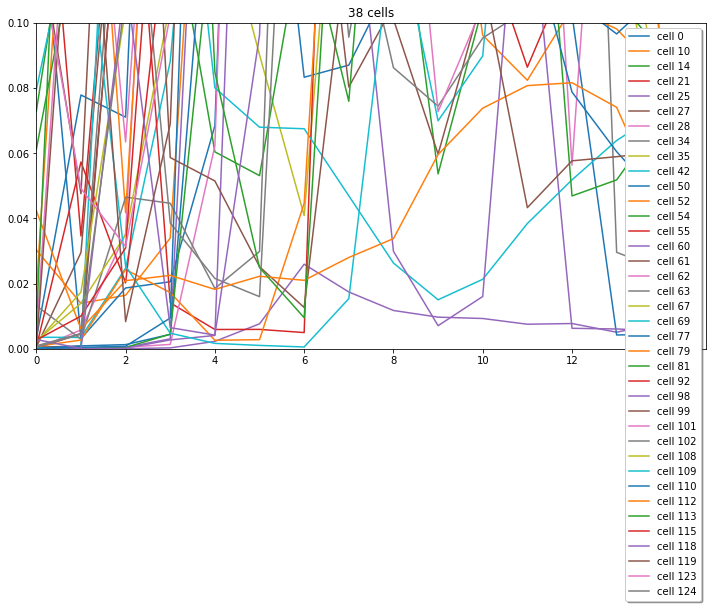

In [51]:
for key, value in cell_types.items():
    print(f'{key}:----------------------')
    Cell.plot(gates_avg['input'], picked=value, show_legend=True)#, ylim=(-1,1))
    Cell.plot(gates_std['input'], picked=value, show_legend=True, ylim=(0,0.1))

## Animate countdown cells

In [52]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

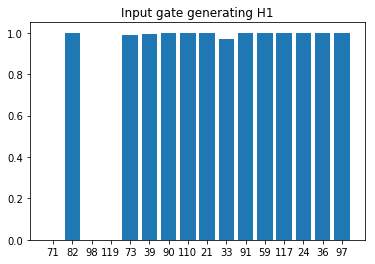

In [53]:
def func(i, gates, cells):
    plt.cla()
    plt.title('Input gate generating H1')
    gate = gates[cells, i]
    plt.bar(range(len(gate)), gate, tick_label=cells)
fig, axes = plt.subplots()
gates = gates_avg['input']
anim = FuncAnimation(fig, func=func, frames=range(gates.shape[1]), fargs=(gates, cd_all), interval=200)
HTML(anim.to_jshtml())
# anim.save('input.gif', writer='imagemagick', fps=6)

## Cluster cells according to behavior

In [54]:
# Cell.analyze(gates_avg['input'], 15)

In [55]:
# Cell.analyze(gates_avg['reset'], 15)

In [56]:
# Cell.analyze(gates_avg['new'], 15, ylim=(-1,1))

In [57]:
# Cell.analyze(gates_avg['hidden'], 15, ylim=(-1,1))